In [25]:
import numpy as np
import torch
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
import torch.nn.functional as F

import pandas as pd
import anndata
import scvelo as scv
import scanpy

from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import kneighbors_graph

In [43]:
root = "./bifur/bifurcating_"
trans_rate = ['1']
splicing_rate = ['5']
deg_rate = ['1']
num_cells = ['300','500']

combined = [(tr, sp, dg, nc) for tr in trans_rate for sp in splicing_rate for dg in deg_rate for nc in num_cells]
data_list = []

adatas = []

for item in combined:
    tr, sp, dg, nc = item
    path = root + tr + "_" + sp + "_" + dg + "_" + nc

    df = pd.read_csv(path + "_unspliced.csv")
    df = df.drop(df.columns[[0]], axis=1)
    X_unspliced = df.to_numpy()

    df = pd.read_csv(path + "_spliced.csv")
    df = df.drop(df.columns[[0]], axis=1)
    X_spliced = df.to_numpy()

    df = pd.read_csv(path + "_cell_info.csv")
    df = df.drop(df.columns[[0]], axis=1)
    X_obs = df

    adata = anndata.AnnData(X = csr_matrix(X_spliced),
                    obs = X_obs,
                    layers = dict(
                        unspliced = csr_matrix(X_unspliced),
                        spliced = csr_matrix(X_spliced)
                    ))

    scv.pp.filter_and_normalize(adata, min_shared_counts=0, n_top_genes=305)

    adata = adata[:,:300]
    print(adata.n_vars)

    adatas.append(adata)

    # compute velocity
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    scv.tl.velocity(adata, mode='stochastic')            
    velo_matrix = adata.layers["velocity"].copy()

    X_spliced = adata.X.toarray()

    pipeline = Pipeline([('pca', PCA(n_components=80, svd_solver='arpack'))])
    X_pca = pipeline.fit_transform(X_spliced)

    # X_pre = X_spliced + velo_matrix/np.linalg.norm(velo_matrix,axis=1)[:,None]*3
    X_pre = X_spliced + velo_matrix

    X_pca_pre = pipeline.transform(X_pre)
    velo_pca = X_pca_pre - X_pca


Transforming to str index.
Normalized count data: X, spliced, unspliced.
Logarithmized X.
300
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Transforming to str index.
Normalized count data: X, spliced, unspliced.
Logarithmized X.
300
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adat

computing velocity graph
... 100%    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


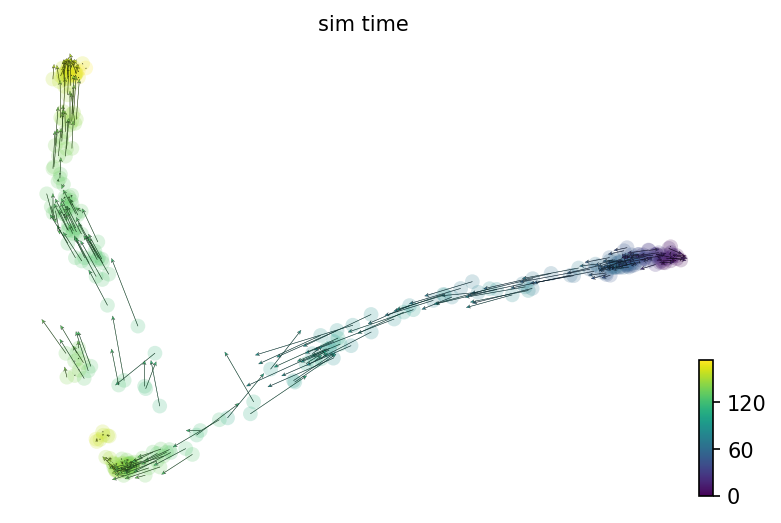

In [49]:
adata = adatas[0]
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding(adata, dpi=150, color=['sim_time'],arrow_length=5)

In [48]:
scv.pl.proportions(adatas[])

IndexError: list index out of range

computing terminal states
    identified 1 region of root cells and 2 regions of end points 
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


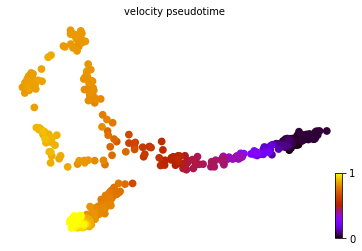

In [30]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot')

In [21]:
adata.obs['velocity_pseudotime']

0      0.889900
1      0.017900
2      0.523280
3      0.522480
4      1.000000
         ...   
295    0.975630
296    0.518503
297    0.522664
298    0.265426
299    0.522833
Name: velocity_pseudotime, Length: 300, dtype: float64